首先匯入 Keras 及相關模組:

In [1]:
import numpy as np
import pandas as pd
from keras.utils import np_utils  # 用來後續將 label 標籤轉為 one-hot-encoding

np.random.seed(10)

Using TensorFlow backend.


下載 Mnist 資料 我們將建立以下 Keras 程式, 下載並讀取 mnist 資料.

Mnist 資料的下載路徑在 ~/.keras/datasets/mnist.npz (npz is a simple zip archive, which contains numpy files.)

In [2]:
from keras.datasets import mnist

讀取與查看 mnist 資料

In [3]:
(X_train_image, y_train_label), (X_test_image, y_test_label) = mnist.load_data()

print("\t[Info] train data={:7,}".format(len(X_train_image)))  
print("\t[Info] test  data={:7,}".format(len(X_test_image))) 

	[Info] train data= 60,000
	[Info] test  data= 10,000


## 查看訓練資料
訓練資料是由 images 與 labels 所組成

In [4]:
print("\t[Info] Shape of train data=%s" % (str(X_train_image.shape)))
print("\t[Info] Shape of train label=%s" % (str(y_train_label.shape)))

	[Info] Shape of train data=(60000, 28, 28)
	[Info] Shape of train label=(60000,)


訓練資料是由 images 與 labels 所組成共有 60,000 筆, 每一筆代表某個數字的影像為 28x28 pixels.
#### 定應 plot_image 函數顯示數字影像

In [5]:
import matplotlib.pyplot as plt
def plot_image(image):
    fig = plt.gcf()
    fig.set_size_inches(2, 2)
    plt.imshow(image, cmap='binary') # cmap='binary' 參數設定以黑白灰階顯示
    plt.show()

#### 執行 plot_image 函數查看第 0 筆數字影像與 label 資料
以下程式呼叫 plot_image 函數, 傳入 X_train_image[0], 也就是順練資料集的第 0 筆資料, 顯示結果可以看到這是一個數字 5 的圖形:

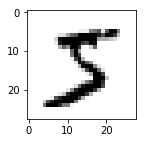

In [6]:
plot_image(X_train_image[0])

再來看看解答

In [7]:
y_train_label[0]

5

#### 建立 plot_images_labels_predict() 函數

In [8]:
def plot_images_labels_predict(images, labels, prediction, idx, num=10):  
    fig = plt.gcf()  
    fig.set_size_inches(12, 14)  
    if num > 25: num = 25  
    for i in range(0, num):  
        ax=plt.subplot(5,5, 1+i)  
        ax.imshow(images[idx], cmap='binary')  
        title = "l=" + str(labels[idx])  
        if len(prediction) > 0:  
            title = "l={},p={}".format(str(labels[idx]), str(prediction[idx]))  
        else:  
            title = "l={}".format(str(labels[idx]))  
        ax.set_title(title, fontsize=10)  
        ax.set_xticks([]); ax.set_yticks([])  
        idx+=1  
    plt.show()

#### 查看訓練資料的前 10 筆資料

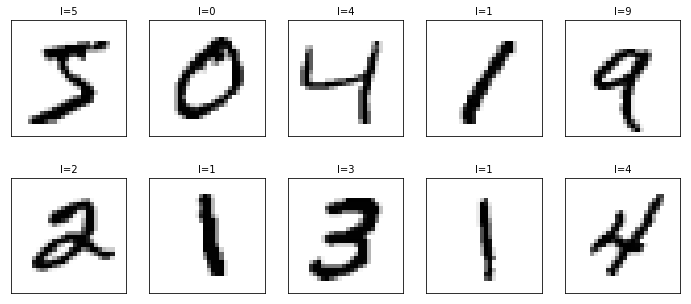

In [9]:
plot_images_labels_predict(X_train_image, y_train_label, [], 0, 10)

#### 多層感知器模型資料前處理
接下來我們建立 多層感知器模型 (MLP), 我們必須先將 images 與 labels 的內容進行前處理, 才能餵進去 Keras 預期的資料結構。

### features (數字影像的特徵值) 資料前處理
首先將 image 以 reshape 轉換為二維 ndarray 並進行 normalization (Feature scaling):

In [10]:
x_Train = X_train_image.reshape(60000, 28*28).astype('float32')
x_Test = X_test_image.reshape(10000, 28*28).astype('float32')
print("\t[Info] xTrain: %s" % (str(x_Train.shape)))
print("\t[Info] xTest: %s" % (str(x_Test.shape)))
  
# Normalization
x_Train_norm = x_Train/255
x_Test_norm = x_Test/255

	[Info] xTrain: (60000, 784)
	[Info] xTest: (10000, 784)


### labels (影像數字真實的值) 資料前處理
label 標籤欄位原本是 0-9 數字, 而為了配合 Keras 的資料格式, 我們必須進行 One-hot-encoding 將之轉換為 10 個 0 或 1 的組合, 例如數字 7 經過 One-hot encoding 轉換後是 0000001000, 正好對應到輸出層的 10 個神經元. 下面簡單測試過程:

In [11]:
y_TrainOneHot = np_utils.to_categorical(y_train_label) # 將 training 的 label 進行 one-hot encoding
y_TestOneHot = np_utils.to_categorical(y_test_label) # 將測試的 labels 進行 one-hot encoding

y_train_label[0] # 檢視 training labels 第一個 label 的值
y_TrainOneHot[:1] # 檢視第一個 label 在 one-hot encoding 後的結果, 會在第六個位置上為 1, 其他位置上為 0

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])

### 建立模型
我們將建立以下多層感知器 Multilayer Perceptron 模型, 輸入層 (x) 共有 28x28=784 個神經元, Hidden layers (h) 共有 256 層; 輸出層 (y) 共有 10 個 神經元:

In [12]:
from keras.models import Sequential  
from keras.layers import Dense  
  
model = Sequential()  # Build Linear Model  
  
model.add(Dense(units=256, input_dim=784, kernel_initializer='normal', activation='relu')) # Add Input/hidden layer  
model.add(Dense(units=10, kernel_initializer='normal', activation='softmax')) # Add Hidden/output layer  
print("\t[Info] Model summary:")  
model.summary()  
print("")

	[Info] Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________



### 定義訓練方式

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])

### 開始訓練

In [14]:
train_history = model.fit(x=x_Train_norm, 
                          y=y_TrainOneHot, 
                          validation_split=0.2, 
                          epochs=10, 
                          batch_size=200, 
                          verbose=2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
 - 3s - loss: 0.4491 - acc: 0.8790 - val_loss: 0.2486 - val_acc: 0.9319
Epoch 2/10
 - 1s - loss: 0.2272 - acc: 0.9359 - val_loss: 0.1871 - val_acc: 0.9481
Epoch 3/10
 - 1s - loss: 0.1726 - acc: 0.9512 - val_loss: 0.1561 - val_acc: 0.9575
Epoch 4/10
 - 1s - loss: 0.1377 - acc: 0.9614 - val_loss: 0.1361 - val_acc: 0.9609
Epoch 5/10
 - 1s - loss: 0.1135 - acc: 0.9680 - val_loss: 0.1206 - val_acc: 0.9659
Epoch 6/10
 - 1s - loss: 0.0955 - acc: 0.9733 - val_loss: 0.1123 - val_acc: 0.9668
Epoch 7/10
 - 1s - loss: 0.0819 - acc: 0.9779 - val_loss: 0.1043 - val_acc: 0.9707
Epoch 8/10
 - 1s - loss: 0.0715 - acc: 0.9803 - val_loss: 0.0968 - val_acc: 0.9724
Epoch 9/10
 - 1s - loss: 0.0628 - acc: 0.9827 - val_loss: 0.0916 - val_acc: 0.9736
Epoch 10/10
 - 1s - loss: 0.0553 - acc: 0.9853 - val_loss: 0.0876 - val_acc: 0.9749


### 建立 show_train_history 顯示訓練過程

In [15]:
import matplotlib.pyplot as plt  
def show_train_history(train_history, train, validation):  
    plt.plot(train_history.history[train])  
    plt.plot(train_history.history[validation])  
    plt.title('Train History')  
    plt.ylabel(train)  
    plt.xlabel('Epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.show()

顯示圖案

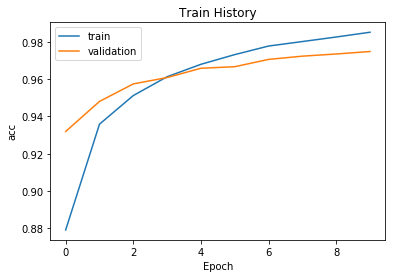

In [16]:
show_train_history(train_history, 'acc', 'val_acc')

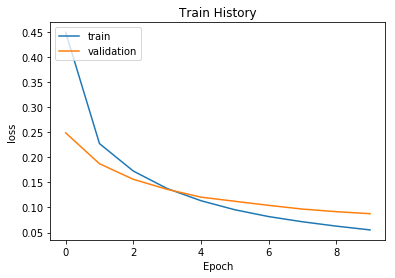

In [17]:
show_train_history(train_history, 'loss', 'val_loss')

### 評估模型準確率

In [18]:
scores = model.evaluate(x_Test_norm, y_TestOneHot)  
print()  
print("\t[Info] Accuracy of testing data = {:2.1f}%".format(scores[1]*100.0))

10000/10000 [==============================] - 1s 61us/step

	[Info] Accuracy of testing data = 97.5%


### 進行預測

	[Info] Making prediction to x_Test_norm

	[Info] Show 10 prediction result (From 240):
[5 9 8 7 2 3 0 2 4 2]



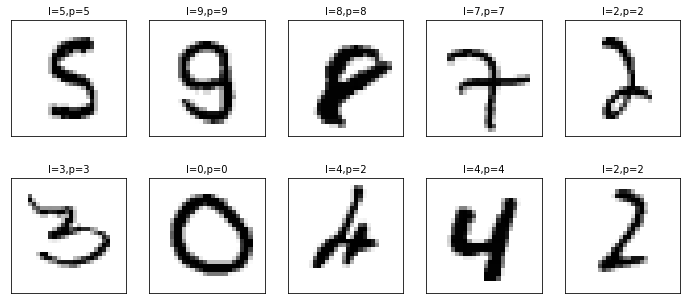

In [19]:
print("\t[Info] Making prediction to x_Test_norm")  
prediction = model.predict_classes(x_Test_norm)  # Making prediction and save result to prediction  
print()  
print("\t[Info] Show 10 prediction result (From 240):")  
print("%s\n" % (prediction[240:250]))  
  
plot_images_labels_predict(X_test_image, y_test_label, prediction, idx=240)